# Mortgage book 

Now that you are familiar with the portfolio and personal loans and risk are using your model as a guide to loss provisions for the upcoming year, the team now asks you to look at their mortgage book. They suspect that FICO scores will provide a good indication of how likely a customer is to default on their mortgage. Charlie wants to build a machine learning model that will predict the probability of default, but while you are discussing the methodology, she mentions that the architecture she is using requires categorical data. As FICO ratings can take integer values in a large range, they will need to be mapped into buckets. She asks if you can find the best way of doing this to allow her to analyze the data.

A FICO score is a standardized credit score created by the Fair Isaac Corporation (FICO) that quantifies the creditworthiness of a borrower to a value between 300 to 850, based on various factors. FICO scores are used in 90% of mortgage application decisions in the United States. The risk manager provides you with FICO scores for the borrowers in the bank’s portfolio and wants you to construct a technique for predicting the PD (probability of default) for the borrowers using these scores. 

Charlie wants to make her model work for future data sets, so she needs a general approach to generating the buckets. Given a set number of buckets corresponding to the number of input labels for the model, she would like to find out the boundaries that best summarize the data. You need to create a rating map that maps the FICO score of the borrowers to a rating where a lower rating signifies a better credit score.

The process of doing this is known as quantization. You could consider many ways of solving the problem by optimizing different properties of the resulting buckets, such as the mean squared error or log-likelihood (see below for definitions). For background on quantization, see here.

Mean squared error

You can view this question as an approximation problem and try to map all the entries in a bucket to one value, minimizing the associated squared error. We are now looking to minimize the following:

Log-likelihood

A more sophisticated possibility is to maximize the following log-likelihood function:



Where bi is the bucket boundaries, ni is the number of records in each bucket, ki is the number of defaults in each bucket, and pi = ki / ni is the probability of default in the bucket. This function considers how rough the discretization is and the density of defaults in each bucket. This problem could be addressed by splitting it into subproblems, which can be solved incrementally (i.e., through a dynamic programming approach). For example, you can break the problem into two subproblems, creating five buckets for FICO scores ranging from 0 to 600 and five buckets for FICO scores ranging from 600 to 850. Refer to this page for more context behind a likelihood function. This page may also be helpful for background on dynamic programming. 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [2]:

df = pd.read_csv('Task 3 and 4_Loan_Data.csv')
df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [3]:
fico_bins = [800, 750, 700, 650, 600, 500, 400, 300, 200, 0]

In [4]:
def get_fico_bin(fico_bins, x):
    if x >= fico_bins[0]:
        return 1
    elif x >= fico_bins[1]:
        return 2
    elif x >= fico_bins[2]:
        return 3
    elif x >= fico_bins[3]:
        return 4
    elif x >= fico_bins[4]:
        return 5
    elif x >= fico_bins[5]:
        return 6
    elif x >= fico_bins[6]:
        return 7
    elif x >= fico_bins[7]:
        return 8
    elif x >= fico_bins[8]:
        return 9
    elif x >= fico_bins[9]:
        return 1
    

In [5]:
def assign_score(data, fico_bins):  
    data['fico'] = data['fico_score'].apply( lambda x : get_fico_bin(fico_bins, x))
    #data.drop(columns=['fico_score'], inplace=True)

In [6]:
assign_score(df, fico_bins)
df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,fico
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,5
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,6
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,5
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,5
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,5
...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0,4
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0,5
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0,6
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0,5


In [7]:
count_no_default = len(df[df['default']==0])
count_default = len(df[df['default']==1])
pct_of_no_default = count_no_default/(count_no_default+count_default)
print("Percentage of no default is", pct_of_no_default*100)
pct_of_default = count_default/(count_no_default+count_default)
print("Percentage of default", pct_of_default*100)

Percentage of no default is 81.49
Percentage of default 18.509999999999998


In [8]:
df.groupby('default').mean()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,fico
default,,,,,,,,
0,4.967005e+06,0.744140,4092.629025,6322.164549,69883.889804,4.765247,646.938765,4.509633
1,5.007914e+06,4.618044,4454.854897,19270.582961,70726.740140,3.617504,596.257699,5.353323


In [9]:
fields = [x for x in df.columns.values if x != 'customer_id' and x!='default']

In [10]:
fields

['credit_lines_outstanding',
 'loan_amt_outstanding',
 'total_debt_outstanding',
 'income',
 'years_employed',
 'fico_score',
 'fico']

In [11]:
X = df[fields]
y = df['default']

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [13]:
from sklearn.metrics import accuracy_score
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy of logistic regression classifier on test set: 0.99


In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2683   17]
 [  25  575]]


In [15]:
print(' The result is telling us that we have: ',(confusion_matrix[0,0]+confusion_matrix[1,1]),'correct predictions')
print(' The result is telling us that we have: ',(confusion_matrix[0,1]+confusion_matrix[1,0]),'incorrect predictions')
print(' We have a total predictions of: ',(confusion_matrix.sum()))

 The result is telling us that we have:  3258 correct predictions
 The result is telling us that we have:  42 incorrect predictions
 We have a total predictions of:  3300


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2700
           1       0.97      0.96      0.96       600

    accuracy                           0.99      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.99      0.99      0.99      3300



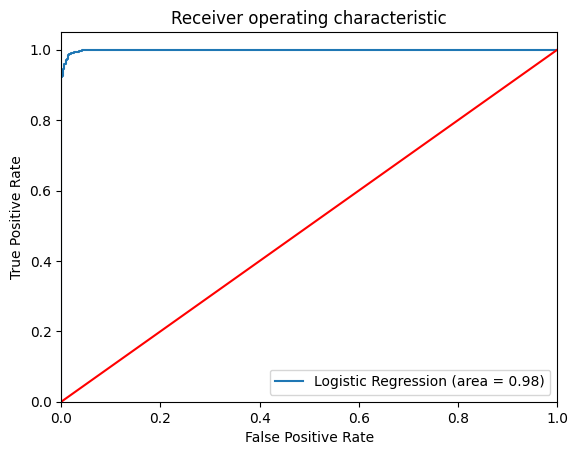

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.savefig('Log_ROC')
plt.show()

In [18]:
df['PD'] = logreg.predict_proba(df[X_train.columns])[:,1]
df[['customer_id', 'PD']].sample(10)

,customer_id,PD
1270,5314585,1.479552e-03
1700,4457453,9.984909e-01
579,4616115,1.425118e-09
8045,5162309,1.273436e-13
1239,4574612,4.972694e-09
4090,4332266,9.999842e-01
6842,1548144,9.999991e-01
3015,5641892,1.378590e-10
2788,1999967,1.205779e-09
9914,5166514,4.098809e-10


In [19]:
X_train.columns

Index(['credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score',
       'fico'],
      dtype='object')

In [20]:

def get_probability_of_default(credit_lines_outstanding, loan_amt_outstanding, total_debt_outstanding, income, years_employed, fico_score):
    
    new_data = np.array([credit_lines_outstanding, loan_amt_outstanding, total_debt_outstanding, income, years_employed, fico_score]).reshape(1, -1)
    new_pred=logreg.predict_proba(new_data)[:,1][0]
    print("This new loan applicant has a {:.2%}".format(new_pred), "chance of defaulting on a new debt")
    
    

In [21]:
import numpy as np
from scipy.optimize import minimize


def model(fico_bins, X, y):
    # here we need to implement your real model for Predicted
    new_fields = [x for x in X.columns.values if x != 'customer_id' and x!='default' and x!='fico_score']
    
    X['fico'] = X['fico_score'].apply( lambda x : get_fico_bin(fico_bins, x))
    
    tmp_df = X[new_fields]
    logreg = LogisticRegression()
    logreg.fit(tmp_df, y)    

    prob_of_default = logreg.predict_proba(tmp_df)[:,1]
    return prob_of_default

def sum_of_squares(fico_bins, X, y):
    prob_of_default = model(fico_bins, X, y)
    obj = np.mean(np.sqrt((prob_of_default ** 2)))
    return obj

df = pd.read_csv('Task 3 and 4_Loan_Data.csv')

assign_score(df, fico_bins)

fields = [x for x in df.columns.values if x != 'customer_id' and x!='default']
X = df[fields]
y = df['default']

# fico bins in descending order
fico_bins = [800, 750, 700, 650, 600, 500, 400, 300, 200, 0]


res = minimize(sum_of_squares, fico_bins, args=(X, y), tol=1e-3, method="Powell")
print(res)
final_bin_boundaries = [round(x) for x in res.x]
print('Boundaries for minimized probability of default: ', final_bin_boundaries)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.1834893473828944
       x: [ 8.037e+02  7.533e+02  6.992e+02  6.492e+02  5.992e+02
            4.992e+02  4.067e+02  3.067e+02  2.067e+02  6.708e+00]
     nit: 3
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 678
Boundaries for minimized probability of default:  [804, 753, 699, 649, 599, 499, 407, 307, 207, 7]
